In [1]:
!git clone https://github.com/kaz-ogiwara/covid19

Cloning into 'covid19'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 970 (delta 15), reused 3 (delta 0), pack-reused 935
Receiving objects: 100% (970/970), 1010.01 KiB | 0 bytes/s, done.
Resolving deltas: 100% (515/515), done.


In [2]:
!pip install japanize_matplotlib

     |████████████████████████████████| 4.1 MB 4.8 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.0.5-py3-none-any.whl size=4118720 sha256=25e9633a14727bc53afa2b766c6618feac9c766f22e10eb1efbb396e81a72999
  Stored in directory: /root/.cache/pip/wheels/0d/1a/0c/3612a5e3227481d4a1dd3566228e3ffe57d608b2b7c08595be
Successfully built japanize-matplotlib


In [3]:
import datetime
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import japanize_matplotlib
import seaborn as sns

from scipy.integrate import odeint
from scipy.optimize import minimize

import pystan

/opt/conda/lib/python3.6/site-packages/japanize_matplotlib/__init__.py:13: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [4]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [5]:
df_covid = pd.read_csv('covid19/data/prefectures.csv', dtype=str)

# rename columns name
df_covid.columns = ['year', 'month', 'day', 'pref_name', 'confirmed', '_', 'recovered', 'dead']
df_covid = df_covid[['year', 'month', 'day', 'pref_name', 'confirmed', 'recovered', 'dead']]

# create yyyymmdd column
df_covid['month'] = df_covid['month'].str.zfill(2)
df_covid['day'] = df_covid['day'].str.zfill(2)
df_covid['date'] = pd.to_datetime(df_covid['year'] + '-' + df_covid['month'] + '-' + df_covid['day'])
df_covid.drop(columns=['year', 'month', 'day'], inplace=True)

# convert data type
#df_covid[['confirmed', 'recovered', 'dead']] = df_covid[['confirmed', 'recovered', 'dead']].astype(int)
for c in ['confirmed', 'recovered', 'dead']:
    df_covid[c] = pd.to_numeric(df_covid[c], errors='coerce')

# create master of pref_name x date
date_arr = pd.date_range(start=df_covid['date'].min(), end=df_covid['date'].max(), freq='D').tolist()
pref_arr = [
    '北海道','青森県','岩手県','宮城県','秋田県','山形県','福島県','茨城県','栃木県','群馬県','埼玉県','千葉県','東京都','神奈川県','新潟県','富山県',
    '石川県','福井県','山梨県','長野県','岐阜県','静岡県','愛知県','三重県','滋賀県','京都府','大阪府','兵庫県','奈良県','和歌山県','鳥取県','島根県',
    '岡山県','広島県','山口県','徳島県','香川県','愛媛県','高知県','福岡県','佐賀県','長崎県','熊本県','大分県','宮崎県','鹿児島県','沖縄県',
]

# merge to master
df_covid = pd.merge(
    pd.DataFrame(list(product(pref_arr, date_arr)), columns=['pref_name', 'date']),
    df_covid,
    how='left',
    on=['pref_name', 'date'],
)

df_covid

,pref_name,date,confirmed,recovered,dead
0,北海道,2020-03-18,153.0,69.0,6.0
1,北海道,2020-03-19,156.0,69.0,6.0
2,北海道,2020-03-20,157.0,69.0,6.0
3,北海道,2020-03-21,158.0,81.0,6.0
4,北海道,2020-03-22,161.0,83.0,6.0
...,...,...,...,...,...
1969,沖縄県,2020-04-24,133.0,11.0,4.0
1970,沖縄県,2020-04-25,133.0,11.0,4.0
1971,沖縄県,2020-04-26,133.0,11.0,4.0
1972,沖縄県,2020-04-27,137.0,23.0,4.0


In [6]:
pref_dic = {
    'Hokkaido': '北海道',
    'Aomori': '青森県',
    'Iwate': '岩手県',
    'Miyagi': '宮城県',
    'Akita': '秋田県',
    'Yamagata': '山形県',
    'Fukushima': '福島県',
    'Ibaragi': '茨城県',
    'Tochigi': '栃木県',
    'Gunma': '群馬県',
    'Saitama': '埼玉県',
    'Chiba': '千葉県',
    'Tokyo': '東京都',
    'Kanagawa': '神奈川県',
    'Nigata': '新潟県',
    'Toyama': '富山県',
    'Ishikawa': '石川県',
    'Fukui': '福井県',
    'Yamanashi': '山梨県',
    'Nagano': '長野県',
    'Gifu': '岐阜県',
    'Shizuoka': '静岡県',
    'Aichi': '愛知県',
    'Mie': '三重県',
    'Shiga': '滋賀県',
    'Kyoto': '京都府',
    'Osaka': '大阪府',
    'Hyogo': '兵庫県',
    'Nara': '奈良県',
    'Wakayama': '和歌山県',
    'Tottori': '鳥取県',
    'Shimane': '島根県',
    'Okayama': '岡山県',
    'Hiroshima': '広島県',
    'Yamaguchi': '山口県',
    'Tokushima': '徳島県',
    'Kagawa': '香川県',
    'Ehime': '愛媛県',
    'Kochi': '高知県',
    'Fukuoka': '福岡県',
    'Saga': '佐賀県',
    'Nagasaki': '長崎県',
    'Kumamoto': '熊本県',
    'Oita': '大分県',
    'Miyazaki': '宮崎県',
    'Kagoshima': '鹿児島県',
    'Okinawa': '沖縄県',
}

In [7]:
# 統計名 人口推計 2019年10月1日現在人口推計
# 表番号 004
# 表題 都道府県，男女別人口及び人口性比－総人口，日本人人口

# df_population = pd.read_csv('../input/FEH_00200524_200417064839.csv', encoding='sjis', skiprows=1, dtype=str)

# df_population.columns = ['_', 'pref_name', '_', 'population', 'population_m', 'population_w']
# df_population = df_population[['pref_name', 'population', 'population_m', 'population_w']]
# df_population = df_population[df_population['pref_name'] != '全国']

# for c in ['population', 'population_m', 'population_w']:
#     df_population[c] = df_population[c].str.replace(',', '')
#     df_population[c] = df_population[c].astype(int)
#     df_population[c] *= 1000
    
# df_population

In [8]:
# 統計名 医療施設調査 平成３０年医療施設（動態）調査 都道府県編
# 表番号 T12
# 表題 第１２表（報告書第２７表）　病院の病床数，病床－病院の種類・都道府県－指定都市・特別区・中核市（再掲）別

# df_hospital_bed = pd.read_csv('../input/FEH_00450021_200417072515.csv', encoding='sjis', dtype=str)

# df_hospital_bed.columns = ['_', '_', 'pref_name', '_', 'infection_bed', 'general_bed']
# df_hospital_bed = df_hospital_bed[['pref_name', 'infection_bed', 'general_bed']]

# df_hospital_bed.loc[df_hospital_bed['pref_name'] == '東京', 'pref_name'] = '東京都'
# df_hospital_bed.loc[df_hospital_bed['pref_name'] == '大阪', 'pref_name'] = '大阪府'
# df_hospital_bed.loc[df_hospital_bed['pref_name'] == '京都', 'pref_name'] = '京都府'
# df_hospital_bed.loc[df_hospital_bed['pref_name'].str.len() == 2, 'pref_name'] += '県'
# df_hospital_bed.loc[df_hospital_bed['pref_name'] == '神奈川', 'pref_name'] = '神奈川県'
# df_hospital_bed.loc[df_hospital_bed['pref_name'] == '和歌山', 'pref_name'] = '和歌山県'
# df_hospital_bed.loc[df_hospital_bed['pref_name'] == '鹿児島', 'pref_name'] = '鹿児島県'

# for c in ['infection_bed', 'general_bed']:
#     df_hospital_bed[c] = df_hospital_bed[c].str.replace(',', '')
#     df_hospital_bed[c] = df_hospital_bed[c].astype(int)
    
# df_hospital_bed

In [9]:
df_tmp = df_covid.copy()
df_tmp['I'] = df_tmp['confirmed']
df_tmp['R'] = df_tmp['recovered'] + df_tmp['dead']

In [10]:
target_pref_en = 'Tokyo'
target_pref_name = pref_dic[target_pref_en]

I_obs = df_tmp[df_tmp['pref_name'] == target_pref_name]['I'].astype(int).values
R_obs = df_tmp[df_tmp['pref_name'] == target_pref_name]['R'].astype(int).values

dates = df_tmp[df_tmp['pref_name'] == target_pref_name]['date']

I_obs

array([ 105,  112,  123,  130,  132,  146,  160,  201,  227,  227,  362,
        430,  443,  521,  587,  684,  773,  891, 1033, 1116, 1195, 1338,
       1519, 1705, 1902, 2068, 2158, 2319, 2446, 2595, 2794, 2975, 3082,
       3184, 3307, 3439, 3572, 3733, 3836, 3908, 3947, 4059])

In [11]:
def sir(y, t, beta, gamma):
    
    dydt1 = -beta * y[0] * y[1]
    dydt2 = beta * y[0] * y[1] - gamma * y[1]
    dydt3 = gamma * y[1]
    
    return [dydt1, dydt2, dydt3]

def estimate(ini_state, beta, gamma):
    
    y_hat = odeint(sir, ini_state, ts, args=(beta, gamma))
    est = y_hat[0:int(t_max / dt):int(1 / dt)]
    
    return est[:, 0], est[:, 1], est[:, 2]

def likelihood(params): # params = [beta, gamma]
    
    _, I_est, R_est = estimate(ini_state, params[0], params[1])
    
    return np.sum((I_est - I_obs)**2 + (R_est - R_obs)**2)

In [12]:
N = int((I_obs[-1] + R_obs[-1]) * 1.5)
S0, I0, R0 = int(N - I_obs[0] - R_obs[0]), int(I_obs[0]), int(R_obs[0])
ini_state = [S0, I0, R0]

beta, gamma = 1e-6, 1e-3

beta, gamma, ini_state

(1e-06, 0.001, [8005, 105, 32])

In [13]:
t_max = len(I_obs)
dt = 0.01
ts = np.arange(0, t_max, dt)

In [14]:
mnmz = minimize(likelihood, [beta, gamma], method="nelder-mead") # optimize logscale likelihood function

mnmz

 final_simplex: (array([[1.78169209e-05, 1.88211512e-02],
       [1.78169392e-05, 1.88212536e-02],
       [1.78169402e-05, 1.88212265e-02]]), array([2133869.22549074, 2133869.22549226, 2133869.22551036]))
           fun: 2133869.225490737
       message: 'Optimization terminated successfully.'
          nfev: 134
           nit: 71
        status: 0
       success: True
             x: array([1.78169209e-05, 1.88211512e-02])

In [15]:
n_pred = 50

t_max = len(I_obs) + n_pred
ts = np.arange(0, t_max, dt)

dates = dates.tolist()
d = dates[-1]
for _ in range(n_pred):
    d = d + datetime.timedelta(days=1)
    dates.append(d)

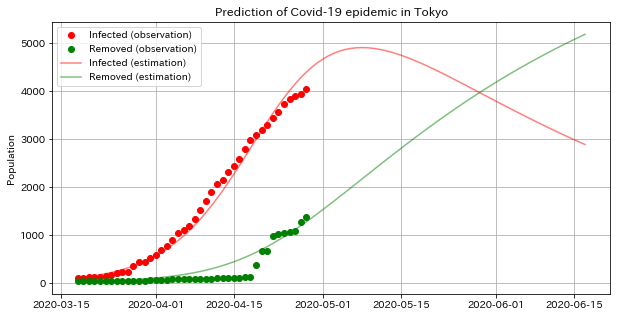

In [16]:
plt.figure(figsize=(10, 5))

plt.plot(dates, list(I_obs) + [None] * n_pred, "o", color="red",label="Infected (observation)")
plt.plot(dates, list(R_obs) + [None] * n_pred, "o", color="green",label="Removed (observation)")

_, I_est, R_est = estimate(ini_state, mnmz.x[0], mnmz.x[1])

plt.plot(dates, I_est, color="red", alpha=0.5, label="Infected (estimation)")
plt.plot(dates, R_est, color="green", alpha=0.5, label="Removed (estimation)")

plt.ylabel('Population')
plt.title('Prediction of Covid-19 epidemic in ' + target_pref_en)
plt.grid()
plt.legend()
plt.show()

In [17]:
model_code = """
functions {
    real[] sir(
        real t,
        real[] y,
        real[] theta,
        real[] x_r,
        int[] x_i
    ) {
        real dydt[3];
        dydt[1] <- - theta[1] * y[1] * y[2];
        dydt[2] <- theta[1] * y[1] * y[2] - theta[2] * y[2];
        dydt[3] <- theta[2] * y[2];
        return dydt;
    }
}
data {
    int<lower=1> T;
    int<lower=1> T_pred;
    real Y0[3];
    int I_obs[T];
    int R_obs[T];
    real T0;
    real TS[T+T_pred];
}
transformed data {
    real x_r[0];
    int x_i[0];
}
parameters {
    real<lower=0, upper=1> beta;
    real<lower=0, upper=1> gamma;
}
transformed parameters {
    real y_hat[T+T_pred, 3];
    real theta[2];
    theta[1] = beta;
    theta[2] = gamma;
    y_hat <- integrate_ode(sir, Y0, T0, TS, theta, x_r, x_i);
}
model {
    real lambda_i[T];
    real lambda_r[T];
    theta[1] ~ normal(1e-6, 1e-3);
    theta[2] ~ normal(1e-3 ,1e-3);
    for (t in 1:T) {
        lambda_i[t] = y_hat[t ,2];
        lambda_r[t] = y_hat[t, 3];
    }
    I_obs ~ poisson(lambda_i);
    R_obs ~ poisson(lambda_r);
}
"""

In [18]:
ts = np.arange(0, t_max, 1)

In [19]:
data = {
    'T': len(I_obs) - 1,
    'T_pred': n_pred,
    'Y0': ini_state,
    'I_obs': I_obs[1:],
    'R_obs': R_obs[1:],
    'T0': ts[0],
    'TS': ts[1:],
}

In [20]:
model = pystan.StanModel(model_code=model_code)

In [21]:
fit = model.sampling(
    data=data,
    iter=15000,
    warmup=5000,
    thin=50,
    chains=3,
    seed=19,
)

In [22]:
fit_dic = fit.extract()

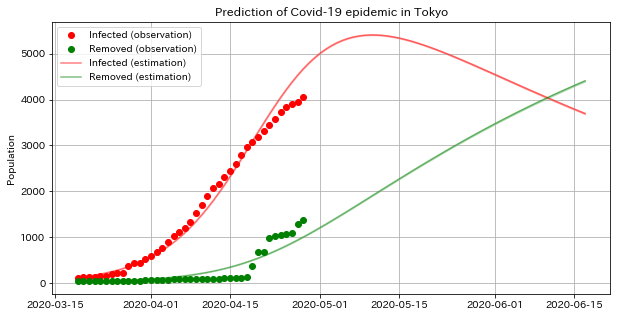

In [23]:
x = dates[1:]

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, list(I_obs[1:]) + [None] * n_pred, marker='o', color='r', linestyle='None', label='Infected (observation)')
ax.plot(x, list(R_obs[1:]) + [None] * n_pred, marker='o', color='g', linestyle='None', label='Removed (observation)')

I_samples = fit_dic['y_hat'][:, :, 1]
medians = np.median(I_samples, axis=0)
lower, upper = np.percentile(I_samples, q=[25.0, 75.0], axis=0)
ax.plot(x, medians, color='r', alpha=0.5, label='Infected (estimation)')
ax.fill_between(x, lower, upper, color='r', alpha=0.2)

R_samples = fit_dic['y_hat'][:, :, 2]
medians = np.median(R_samples, axis=0)
lower, upper = np.percentile(R_samples, q=[25.0, 75.0], axis=0)
ax.plot(x, medians, color='g', alpha=0.5, label='Removed (estimation)')
ax.fill_between(x, lower, upper, color='g', alpha=0.2)

plt.ylabel('Population')
plt.title('Prediction of Covid-19 epidemic in ' + target_pref_en)
plt.grid()
plt.legend()
plt.show()

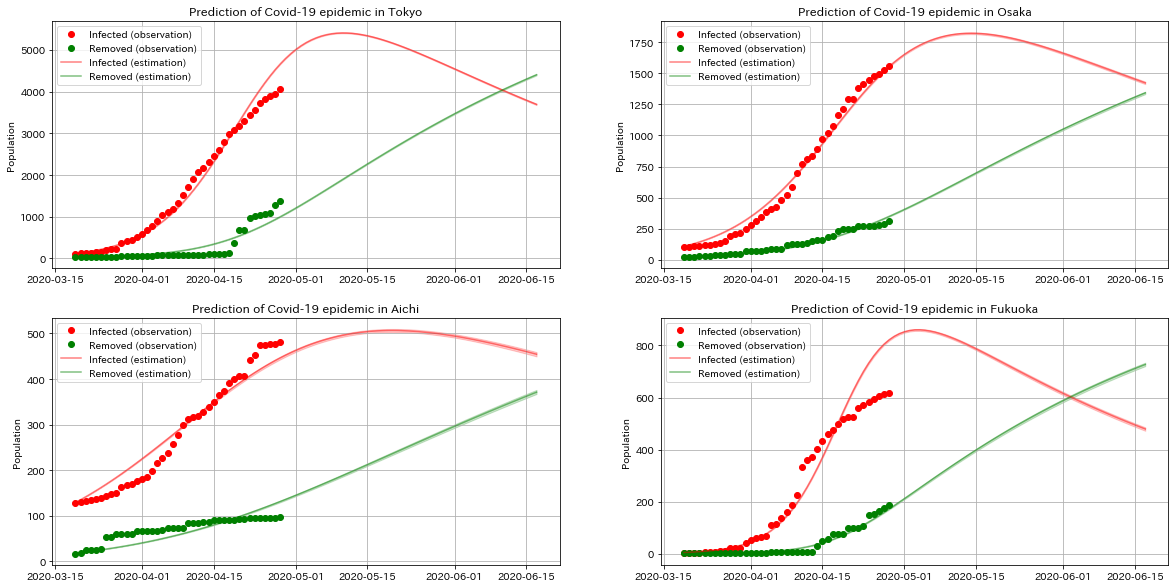

In [24]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))
axs = axs.flatten()

for i, target_pref_en in enumerate(['Tokyo', 'Osaka', 'Aichi', 'Fukuoka']):
    
    target_pref_name = pref_dic[target_pref_en]
    
    I_obs = df_tmp[df_tmp['pref_name'] == target_pref_name]['I'].astype(int).values
    R_obs = df_tmp[df_tmp['pref_name'] == target_pref_name]['R'].astype(int).values
    
    dates = df_tmp[df_tmp['pref_name'] == target_pref_name]['date']
    
    N = int((I_obs[-1] + R_obs[-1]) * 1.5)
    S0, I0, R0 = int(N - I_obs[0] - R_obs[0]), int(I_obs[0]), int(R_obs[0])
    ini_state = [S0, I0, R0]

    n_pred = 50
    t_max = len(I_obs) + n_pred

    dates = dates.tolist()
    d = dates[-1]
    for _ in range(n_pred):
        d = d + datetime.timedelta(days=1)
        dates.append(d)
    
    ts = np.arange(0, t_max, 1)
    
    data = {
        'T': len(I_obs) - 1,
        'T_pred': n_pred,
        'Y0': ini_state,
        'I_obs': I_obs[1:],
        'R_obs': R_obs[1:],
        'T0': ts[0],
        'TS': ts[1:],
    }
    
    model = pystan.StanModel(model_code=model_code)
    
    fit = model.sampling(
        data=data,
        iter=15000,
        warmup=5000,
        thin=50,
        chains=3,
        seed=19,
    )
    
    fit_dic = fit.extract()
    
    x = dates[1:]

    axs[i].plot(x, list(I_obs[1:]) + [None] * n_pred, marker='o', color='r', linestyle='None', label='Infected (observation)')
    axs[i].plot(x, list(R_obs[1:]) + [None] * n_pred, marker='o', color='g', linestyle='None', label='Removed (observation)')

    I_samples = fit_dic['y_hat'][:, :, 1]
    medians = np.median(I_samples, axis=0)
    lower, upper = np.percentile(I_samples, q=[25.0, 75.0], axis=0)
    axs[i].plot(x, medians, color='r', alpha=0.5, label='Infected (estimation)')
    axs[i].fill_between(x, lower, upper, color='r', alpha=0.2)

    R_samples = fit_dic['y_hat'][:, :, 2]
    medians = np.median(R_samples, axis=0)
    lower, upper = np.percentile(R_samples, q=[25.0, 75.0], axis=0)
    axs[i].plot(x, medians, color='g', alpha=0.5, label='Removed (estimation)')
    axs[i].fill_between(x, lower, upper, color='g', alpha=0.2)

    axs[i].set_ylabel('Population')
    axs[i].set_title('Prediction of Covid-19 epidemic in ' + target_pref_en)

    axs[i].grid()
    axs[i].legend()

plt.show()

In [25]:
results_pref = []
results_beta = []
results_gamma = []

for i, target_pref_en in enumerate(list(pref_dic.keys())):
    
    print(i)
    
    try:
        
        target_pref_name = pref_dic[target_pref_en]

        I_obs = df_tmp[df_tmp['pref_name'] == target_pref_name]['I'].astype(int).values
        R_obs = df_tmp[df_tmp['pref_name'] == target_pref_name]['R'].astype(int).values

        dates = df_tmp[df_tmp['pref_name'] == target_pref_name]['date']

        N = int((I_obs[-1] + R_obs[-1]) * 1.5)
        S0, I0, R0 = int(N - I_obs[0] - R_obs[0]), int(I_obs[0]), int(R_obs[0])
        ini_state = [S0, I0, R0]

        n_pred = 50
        t_max = len(I_obs) + n_pred

        dates = dates.tolist()
        d = dates[-1]
        for _ in range(n_pred):
            d = d + datetime.timedelta(days=1)
            dates.append(d)

        ts = np.arange(0, t_max, 1)

        data = {
            'T': len(I_obs) - 1,
            'T_pred': n_pred,
            'Y0': ini_state,
            'I_obs': I_obs[1:],
            'R_obs': R_obs[1:],
            'T0': ts[0],
            'TS': ts[1:],
        }

        model = pystan.StanModel(model_code=model_code)

        fit = model.sampling(
            data=data,
            iter=15000,
            warmup=5000,
            thin=50,
            chains=3,
            seed=19,
        )

        fit_dic = fit.extract()

        results_beta.append(fit_dic['beta'])
        results_gamma.append(fit_dic['gamma'])
        results_pref.append(target_pref_en)
    
    except:
        
        continue

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


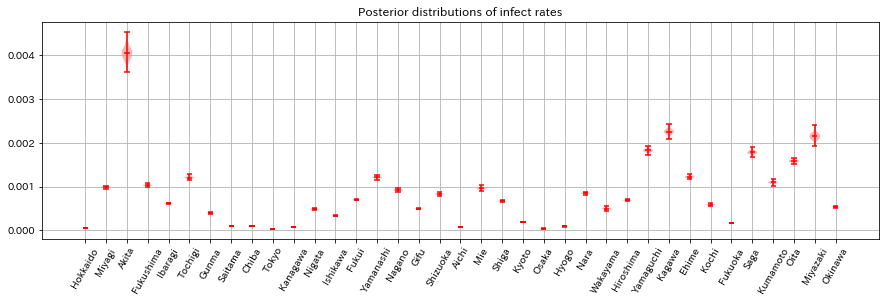

In [26]:
plt.figure(figsize=(15, 4))
for i, p in enumerate(results_pref):
    
    g = plt.violinplot(results_beta[i], positions=[i], showmeans=False, showextrema=True, showmedians=True)
    c = 'red'
    
    for pc in g['bodies']:
        pc.set_facecolor(c)
        
    g['cbars'].set_edgecolor(c)
    g['cmaxes'].set_edgecolor(c)
    g['cmedians'].set_edgecolor(c)
    g['cmins'].set_edgecolor(c)
    
plt.xticks(list(range(len(results_pref))), results_pref)
plt.xticks(rotation=60)
plt.grid()
plt.title('Posterior distributions of infect rates')
plt.show()

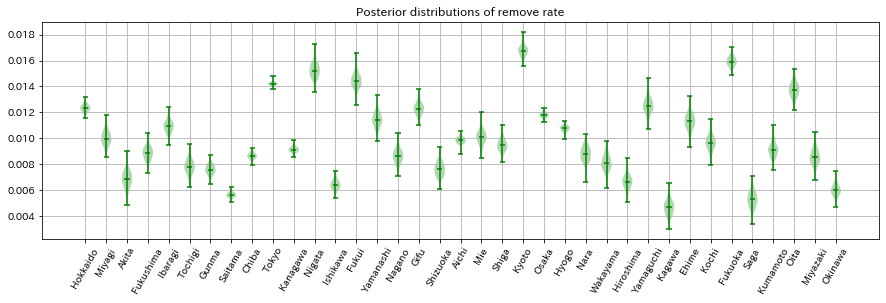

In [27]:
plt.figure(figsize=(15, 4))
for i, p in enumerate(results_pref):
    
    g = plt.violinplot(results_gamma[i], positions=[i], showmeans=False, showextrema=True, showmedians=True)
    c = 'green'
    
    for pc in g['bodies']:
        pc.set_facecolor(c)
        
    g['cbars'].set_edgecolor(c)
    g['cmaxes'].set_edgecolor(c)
    g['cmedians'].set_edgecolor(c)
    g['cmins'].set_edgecolor(c)
    
plt.xticks(list(range(len(results_pref))), results_pref)
plt.xticks(rotation=60)
plt.grid()
plt.title('Posterior distributions of remove rate')
plt.show()